# **1. Import libraries and dependencies**

In [1]:
import os
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import struct
import cv2
from numpy import expand_dims
import tensorflow as tf
from skimage.transform import resize
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D 
from keras.models import load_model, Model
from keras.layers import add, concatenate
from matplotlib import pyplot
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib.patches import Rectangle
%matplotlib inline

/tmp/ipykernel_13/3369566945.py:3: DeprecationWarning: scipy.misc is deprecated and will be removed in 2.0.0
  import scipy.misc
2025-06-23 23:10:00.959203: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750720201.218403      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750720201.293815      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **2.Set the Paths to YOLO Files**

In [2]:
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg

--2025-06-23 23:10:17--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg’

yolov3.cfg          100%[===================>]   8.15K  --.-KB/s    in 0s      

2025-06-23 23:10:17 (46.7 MB/s) - ‘yolov3.cfg’ saved [8342/8342]



In [3]:
cfg_path =  "yolov3.cfg"
weights_path = "/kaggle/input/data-for-yolo-v3-kernel/yolov3.weights"
names_path = "/kaggle/input/data-for-yolo-v3-kernel/coco.names"

# **3.Load YOLOv3 Model and Class Names**

In [4]:
net = cv2.dnn.readNet(weights_path, cfg_path)

with open(names_path, "r") as f:
    classes = [line.strip() for line in f.readlines()]

layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers().flatten()]

# **4. Upload an Image**

In [5]:
image_path = "/kaggle/input/data-for-yolo-v3-kernel/office.jpg"

In [6]:
img = cv2.imread(image_path)
img = cv2.resize(img, None, fx=0.4, fy=0.4)
height, width, channels = img.shape

# **5. Convert Image to Blob**


In [7]:
blob = cv2.dnn.blobFromImage(img, 1/255, (416, 416), (0,0,0), swapRB=True, crop=False)
net.setInput(blob)
outs = net.forward(output_layers)

# **6.Process YOLOv3 Output**

In [8]:
class_ids = []
confidences = []
boxes = []

for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)

            x = int(center_x - w / 2)
            y = int(center_y - h / 2)

            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)


# **7. Apply Non-Max Suppression**

In [9]:
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

# **8. Draw Boxes and Labels**

In [10]:
colors = np.random.uniform(0, 255, size=(len(classes), 3))
font = cv2.FONT_HERSHEY_SIMPLEX

for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        color = colors[class_ids[i]]
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
        cv2.putText(img, label, (x, y - 10), font, 0.6, color, 2)


# **9.Show Final Image**

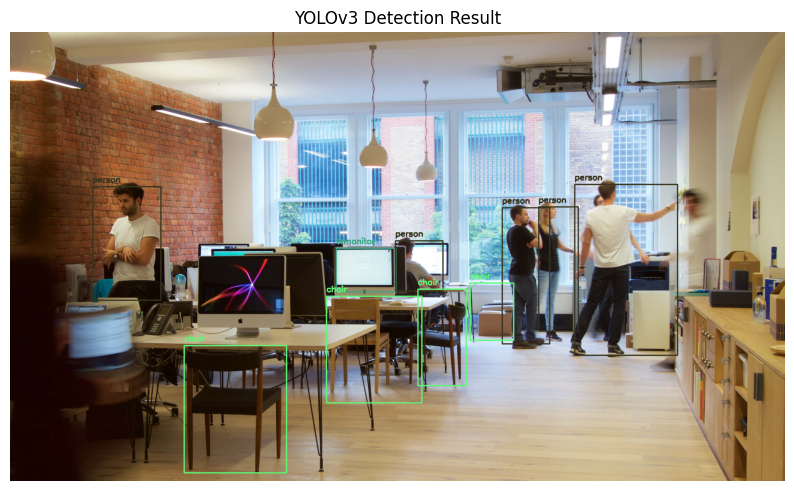

In [11]:
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("YOLOv3 Detection Result")
plt.show()